In [1]:
from langgraph.graph import StateGraph, END,add_messages

from typing import TypedDict, Annotated, Sequence,List, Union
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage,AIMessage,AIMessageChunk,FunctionMessage
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
import json
import re
import google.generativeai as genai
from google.generativeai.types import GenerationConfig
from langchain_core.runnables import Runnable

from dotenv import load_dotenv
import os


load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEYJ")
from langchain_google_genai import ChatGoogleGenerativeAI



In [2]:
genai.configure(api_key=GEMINI_API_KEY)
llm_json = genai.GenerativeModel(
    model_name="gemini-2.0-flash-lite",
    generation_config=GenerationConfig(
        response_mime_type="application/json",
        temperature=0
    )
)


In [3]:
llm_json

genai.GenerativeModel(
    model_name='models/gemini-2.0-flash-lite',
    generation_config={'temperature': 0, 'response_mime_type': 'application/json'},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

In [4]:
api_key2 = os.getenv("GEMINI_API_KEYY")


In [5]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",google_api_key=  api_key2 )

llm.invoke("hi").content



'Hi there! How can I help you today?'

In [6]:
print(llm)

model='models/gemini-2.0-flash-lite' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000026EAFCBBF50> default_metadata=() model_kwargs={}


# tools

In [ ]:

@tool
def run_phq9_assessment() -> dict:
    """Run PHQ-9 depression screening assessment FOR user if it is needed"""
    print("🔧 Running PHQ-9 Assessment")
    questions = [
        "Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?",
        "How often have you felt down, depressed, or hopeless?",
        "How often have you had trouble falling or staying asleep?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "PHQ9", "score": score}


@tool
def run_gad7_assessment() -> dict:
    """Run GAD-7 anxiety screening assessment FOR user if it is needed"""

   

    print("🔧 Running GAD-7 Assessment")
    questions = [
        "Have you been feeling nervous or on edge?",
        "Do you find it difficult to stop worrying?",
        "Do you feel easily irritated?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "GAD7", "score": score}




In [ ]:

tools = [run_phq9_assessment, run_gad7_assessment]

llm = llm.bind_tools(tools)


In [ ]:
class AgentState(TypedDict):
   
    messages: Annotated[Sequence[BaseMessage], add_messages]


    # Intake information
    presenting_problem: str       
    history: str                

    #  Case formulation (abc model)
    activating_event: str        
    beliefs: List[str]           
    consequences: List[str]       

  
    # LLM & Routing
           
    next_node: Union[str,bool]                   

  

In [ ]:
def print_red(text):
    print(f"\033[31m{text}\033[0m")

In [ ]:
print_red("            GOT JSON OR NOT-----------")

            GOT JSON OR NOT-----------


In [ ]:
def intake_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content
   
    prompt = (
        "You are a CBT assistant.\n"
        "Extract the user's presenting problem and a brief emotional history from this message:\n\n"
        "Respond ONLY with valid JSON in this exact format:\n"
        f"User message: {user_input}\n\n"
        "{\n"
        "  \"presenting_problem\": \"...\",\n"
        "  \"history\": \"...\"\n"
        "}"
    )

    response = llm_json.generate_content(prompt)


    response_content = response.text
   
    if isinstance(response_content, str):
      
        json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', response_content, re.DOTALL)
        if json_match:
            response_content = json_match.group(1)
        else:
            
            json_match = re.search(r'\{.*?\}', response_content, re.DOTALL)
            if json_match:
                response_content = json_match.group(0)
    
   
    try:
        if isinstance(response_content, dict):
            result = response_content
        else:
            result = json.loads(response_content)
    except (json.JSONDecodeError, TypeError):
     
        result = {
            "presenting_problem": user_input,
            "history": "No specific history provided"
        }


    presenting_problem = result.get("presenting_problem", "")
    history = result.get("history", "")  
    
    
    state['presenting_problem'] = presenting_problem
    state['history'] = history
    
    t = FunctionMessage(
        name="t",
        content=f'{{"presenting_problem": "{presenting_problem}", "history": "{history}"}}'
    ) 

    prompt = ( f"You are a CBT assistant. Acknowledge that you understand the user's situation from their problem: {presenting_problem} and history: {history}. Respond in just 3 lines." )

    msg=llm.invoke(prompt)
    state["messages"].append( AIMessage(content=msg.content) )

    print_red("                  --------------INTAKE NODE   OUT---------------------")

   
    return {
        "presenting_problem": presenting_problem,
        "history": history,  
        'messages' :  [ t ]
    }

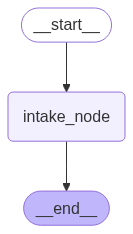

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.set_entry_point("intake_node")
graph.set_finish_point("intake_node")
graph.compile()


# invoking

In [ ]:
user_input = "I yelled at my son today. I feel like a horrible parent."
messages = [HumanMessage(content=user_input)]
    
  
initial_state = {         
        "messages": messages, 
    }

In [ ]:
app = graph.compile()


if __name__ == "__main__":
    user_input = "I yelled at my son today. I feel like a horrible parent."
    messages = [HumanMessage(content=user_input)]
    
   
    initial_state = {         
        "messages": messages, 
    }
    
    
    print("Invoking the CBT chatbot graph...")
    output = app.invoke(initial_state)


Invoking the CBT chatbot graph...
 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son
                  --------------INTAKE NODE   OUT---------------------


In [ ]:
output["messages"]

[HumanMessage(content='I yelled at my son today. I feel like a horrible parent.', additional_kwargs={}, response_metadata={}, id='ffbf9112-55d0-443b-ba6b-9e940ea98c3c'),
 AIMessage(content="I understand you're feeling like a horrible parent because you've been yelling at your son. It's common to feel this way. Let's work together to find some strategies to manage your reactions and improve your relationship with your son.", additional_kwargs={}, response_metadata={}, id='6b429397-90c2-4994-a480-40040822658d'),
 FunctionMessage(content='= presenting Problem = Yelling at son = history = Feels like a horrible parent', additional_kwargs={}, response_metadata={}, name='t', id='7ccba287-f08a-4927-a8b5-b7070dbcb9a7')]

In [ ]:
for msg in output["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

  HumanMessage: I yelled at my son today. I feel like a horrible parent.
  AIMessage: = presenting Problem = Yelling at son = history = Feels like a horrible parent
  AIMessage: I understand you're feeling like a horrible parent because you've been yelling at your son. It's tough when we don't act the way we want to. Would you like to take a GAD-7 or PHQ-9 assessment to check for anxiety or depression?


In [ ]:
print(output['presenting_problem'])

Yelling at son


In [ ]:
for chunk in app.stream(initial_state,stream_mode="messages"):
    
    print(chunk)

 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son
(AIMessageChunk(content='I understand you', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--84d5de09-fda4-4871-b411-9923cbce8f3d'), {'langgraph_step': 1, 'langgraph_node': 'intake_node', 'langgraph_triggers': ('branch:to:intake_node',), 'langgraph_path': ('__pregel_pull', 'intake_node'), 'langgraph_checkpoint_ns': 'intake_node:a7bc37f5-bf3a-613a-4074-d4919d2853cf', 'checkpoint_ns': 'intake_node:a7bc37f5-bf3a-613a-4074-d4919d2853cf', 'ls_provider': 'google_genai', 'ls_model_name': 'gemini-2.0-flash-lite', 'ls_model_type': 'chat', 'ls_temperature': 0.7})
(AIMessageChunk(content="'re feeling like a horrible parent because you've been yelling at your son", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--84d5de09-fda4-4871-b411-9923cbce8f3d'), {'langgraph_step': 1, 'langgraph_node': 'intake_node', 'langgraph_triggers': ('branch:to:intake_nod

# case formualtin node

In [ ]:
def case_formulation_node( state: AgentState) -> AgentState:
        
       

        prompt = (
            "You are a CBT assistant.\n"
            "Given this user's presenting problem, extract as much of the ABC model as possible:\n"
            "- A (Activating Event): what clearly happened?\n"
            "- B (Beliefs): only include if user directly stated their thoughts or judgments\n"
            "- C (Consequences): only include if emotions or actions are clearly stated\n\n"
            f"Presenting Problem:\n{  state["presenting_problem"]}\n\n"
            f"histroy:\n {state["history"]}\n\n"
            "Respond in this EXACT format:\n"
            "{\n"
            "  \"activating_event\": \"...\",\n"
            "  \"beliefs\": [\"...\", \"...\"],\n"
            "  \"consequences\": [\"...\", \"...\"]\n"
            "}"
        )

        
        response = llm_json.generate_content(prompt)
        
       
        content = response.text.strip()
        
        try:
            result = json.loads(content)
        except:
            result = {}

        print_red("                  --------------case_formulation_node   OUT---------------------")

        return {
            **state,
         
            "messages": [FunctionMessage(name ="t",content=f'{{"activating_event": "{result.get("activating_event", "")}", "beliefs": {result.get("beliefs", [])}, "consequences": {result.get("consequences", [])}}}')],
             
            "activating_event": result.get("activating_event", ""),
            "beliefs": result.get("beliefs", []),
            "consequences": result.get("consequences", [])
        }



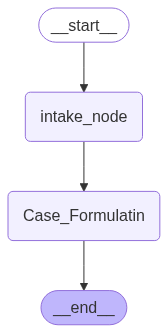

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.add_node("Case_Formulatin", case_formulation_node)

graph.set_entry_point("intake_node")
graph.add_edge("intake_node","Case_Formulatin")
graph.set_finish_point("Case_Formulatin")
graph.compile()

# invoking

In [ ]:
app = graph.compile()

In [ ]:
app = graph.compile()


if __name__ == "__main__":
    user_input = "I yelled at my son today. I feel like a horrible parent."
    messages = [HumanMessage(content=user_input)]
    
    initial_state = {         
        "messages": messages, 
    }
  
    print("Invoking the CBT chatbot graph...")
    output = app.invoke(initial_state)


Invoking the CBT chatbot graph...
 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son
                  --------------INTAKE NODE   OUT---------------------
                  --------------case_formulation_node---------------------
                  --------------case_formulation_node   OUT---------------------


In [ ]:
for msg in output["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

  HumanMessage: I yelled at my son today. I feel like a horrible parent.
  AIMessage: I understand you're struggling with yelling at your son and feeling like a bad parent, which is a really tough situation.
It's common to feel this way when you're not acting in line with your values.
Let's explore some CBT techniques to help you manage your anger and improve your parenting approach.


In [ ]:
output['beliefs']

['Feels like a horrible parent']

In [ ]:
for message_chunk,metadata in app.stream( 
    initial_state,
    stream_mode="messages",
    
):
    print(".........................................")
    print(message_chunk)
    print(".........................................")

    # if message_chunk.content:
    #     print(message_chunk.content,  end = "|",flush=True)

    # print("\n")
    # print()
    # print(metadata)


                  --------------INTAKE NODE---------------------
.........................................
content='```' additional_kwargs={} response_metadata={'safety_ratings': []} id='run--dc7ff0d4-0814-4c29-a60d-e176630a4670'
.........................................
.........................................
content='json\n{\n  "presenting_problem": "Yelling at son' additional_kwargs={} response_metadata={'safety_ratings': []} id='run--dc7ff0d4-0814-4c29-a60d-e176630a4670'
.........................................
.........................................
content=' and feeling like a horrible parent.",\n  "history": "The message indicates' additional_kwargs={} response_metadata={'safety_ratings': []} id='run--dc7ff0d4-0814-4c29-a60d-e176630a4670'
.........................................
.........................................
content=' a recent event (yelling at son) that is causing current negative feelings. There is no information about the duration or frequency of this behavi

In [ ]:
for message_chunk,metadata in app.stream( 
    initial_state,
    stream_mode="messages",
    
):
  

    if message_chunk.content:
         print(message_chunk.content,  end = "|",flush=True)

 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son
I| understand you|'re feeling terrible about yelling at your son and the history of this behavior, leading you| to feel like a bad parent.

It's completely understandable that you're experiencing| these difficult emotions.

Let's work together to explore the thoughts and feelings driving this and develop healthier responses.
|                  --------------INTAKE NODE   OUT---------------------
I understand you're feeling terrible about yelling at your son and the history of this behavior, leading you to feel like a bad parent.

It's completely understandable that you're experiencing these difficult emotions.

Let's work together to explore the thoughts and feelings driving this and develop healthier responses.
|                  --------------case_formulation_node---------------------
                  --------------case_formulation_node   OUT---------------------
{"activating_event"

# Screening Tool

In [ ]:
def should_continue(state: AgentState) -> str:
    
    messages = state["messages"]
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
   
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue"
    else:

        print("Ending tool execution")
        return "end"

In [ ]:

def Screening_Node( state: AgentState) -> AgentState:
            print_red("\n                  --------------Screening_Tool---------------------")

            if state['next_node']:
                   return
       
          
            
            prompt = (
                "You are a CBT therapist doing an Screening Tool test You are provided with user current information Based on The informatin you can run depression and anxiety screening tools. [run_phq9_assessment, run_gad7_assessment].You can run just one tool only.  User information is Shown\n\n"
               
                f"Presenting Problem: {state['presenting_problem']}\n"
                f"history: {state['history']}\n"
                f"Belief: {state['beliefs']}\n"
                f"Consequences: {state['consequences']}\n"
             
          
            )
            
           
            response = llm.invoke([HumanMessage(content=prompt)])
          
         
            if hasattr(response, 'tool_calls') and response.tool_calls:
                for tool_call in response.tool_calls:
                    print_red(f"\n Running {tool_call['name']}...")
                   
                 

            state["next_node"] = True

            print_red("\n                  --------------Screening_Tool  OUT---------------------")

            
            return {
                **state,
                "messages": [response],
                
            }

    

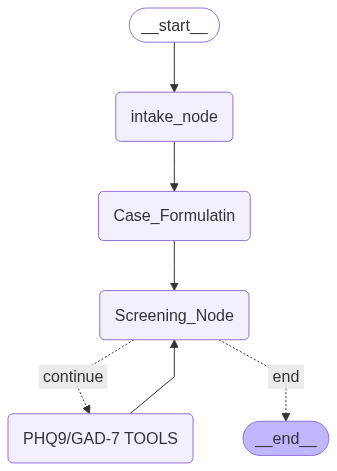

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.add_node("Case_Formulatin", case_formulation_node)
graph.add_node("Screening_Node",Screening_Node)


graph.set_entry_point("intake_node")
graph.add_edge("intake_node","Case_Formulatin")
graph.add_edge("Case_Formulatin","Screening_Node")



# ToolNode()
tool_node = ToolNode(tools=tools)
graph.add_node("PHQ9/GAD-7 TOOLS", tool_node)



graph.add_conditional_edges(
    "Screening_Node",
    should_continue,
   {
        "continue": "PHQ9/GAD-7 TOOLS",
        "end": END,

   }
)

graph.add_edge("PHQ9/GAD-7 TOOLS", "Screening_Node")


graph.set_finish_point("Screening_Node")
graph.compile()

In [ ]:
user_input = "I yelled at my son today. I feel like a horrible parent."

messages = [HumanMessage(content=user_input)]
    

initial_state = {         
        "messages": messages, 
        "next_node" : False
    }

In [ ]:
app = graph.compile()
for message_chunk,metadata in app.stream( 
    initial_state,
    stream_mode="messages",
    
):
  

    if message_chunk.content:
         print(message_chunk.content,  end = "|",flush=True)
         

 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son
I understand you|'re feeling down about yelling at your son and feeling like a bad parent. It|'s tough when we act in ways that go against our values.  Let|'s explore some strategies to manage these feelings and improve your interactions with your son.
|                  --------------INTAKE NODE   OUT---------------------
= presenting Problem = Yelling at son = history = Feels like a horrible parent|                  --------------case_formulation_node---------------------
                  --------------case_formulation_node   OUT---------------------
{"activating_event": "Yelling at son", "beliefs": ['Feels like a horrible parent'], "consequences": []}|                  --------------Screening_Tool---------------------
Okay|, I will run the PHQ-9 and GAD-7 assessments. Based on the| user's information, I will start with the PHQ-9 assessment to| screen for depression.
|response
Okay,

In [ ]:
app = graph.compile()
for message_chunk,metadata in app.stream( 
    initial_state,
    stream_mode="messages",
    
):
  

    if message_chunk.content:
        #print(message_chunk.content,  end = "|",flush=True)
        if isinstance(message_chunk,AIMessageChunk):
            msg_type = type(message_chunk).__name__ 
            print(f"\n[{msg_type}] {message_chunk.content} |", flush=True)
        elif isinstance(message_chunk, ToolMessage):
            print("🛠 Tool Output:", message_chunk.content, end="|", flush=True)

 --------------INTAKE NODE---------------------
            GOT JSON OR NOT-----------
Yelling at son

[AIMessageChunk] I |

[AIMessageChunk]  understand you're struggling with yelling at your son and feeling like a bad parent. It |

[AIMessageChunk] 's tough when we don't act the way we want to. I can help you |

[AIMessageChunk]  explore some strategies to manage these feelings and behaviors. Would you like to start with a quick anxiety or depression assessment?
 |
                  --------------INTAKE NODE   OUT---------------------

[AIMessage] I understand you're struggling with yelling at your son and feeling like a bad parent. It's tough when we don't act the way we want to. I can help you explore some strategies to manage these feelings and behaviors. Would you like to start with a quick anxiety or depression assessment?
 |
                  --------------case_formulation_node---------------------
                  --------------case_formulation_node   OUT---------------------

In [ ]:
user_input = "Hello how can i help you Today. Are you struggling with Any Mental Distress"
messages = [HumanMessage(content=user_input)]
initial_state = {         
            "messages": messages, 
            "next_node" : False
        }

In [ ]:
def take_input():
    user_input = input("Hello how can i help you Today. Are you struggling with Any Mental Distress")
    messages = [HumanMessage(content=user_input)]
        
       
    initial_state = {         
            "messages": messages, 
            "next_node" : False
        }
    return initial_state

In [ ]:
app = graph.compile()
last_type = None  

initial_state = take_input()

print("👱‍♂️  USER:", initial_state["messages"][0].content)

for message_chunk, metadata in app.stream(initial_state, stream_mode="messages"):
    if message_chunk.content:
        msg_type = type(message_chunk).__name__

      
        if msg_type != last_type:

            if  msg_type=="AIMessageChunk":

                 print_red("BOT")
            elif  msg_type== "ToolMessage":

                 print_red(" TOOL Process OUT")
         
            
            last_type = msg_type

        if isinstance(message_chunk, AIMessageChunk):
            print(message_chunk.content, end="", flush=True)
        elif isinstance(message_chunk, ToolMessage):
            print( message_chunk.content, end="|", flush=True)
        elif isinstance(message_chunk, HumanMessage):
            print("👱‍♂️  USER:", message_chunk.content, end="|", flush=True)
        elif isinstance(message_chunk, FunctionMessage):


            if metadata["langgraph_node"] == "intake_node":
                print(7*"  "+"Process Happend in INTAKE NODE ")
                print( message_chunk.content)

            elif metadata["langgraph_node"] == "Case_Formulatin":
                print(7*"  "+"Process Happend in Case Formulatin NODE ")
                print( message_chunk.content)
       



👱‍♂️  USER: I yelled at my son today. I feel like a horrible parent
 --------------INTAKE NODE---------------------
BOT
I understand you're feeling like a horrible parent because you've been yelling at your son. It's tough when we feel like we're not living up to our own expectations. Would you like to take an assessment to evaluate your anxiety or depression?
                  --------------INTAKE NODE   OUT---------------------
              Process Happend in INTAKE NODE 
= presenting Problem = Yelling at son = history = Feels like a horrible parent
                  --------------case_formulation_node---------------------
                  --------------case_formulation_node   OUT---------------------
              Process Happend in Case Formulatin NODE 
{"activating_event": "Yelling at son", "beliefs": ['Feels like a horrible parent'], "consequences": []}

                  --------------Screening_Tool---------------------
BOT
Okay, I will run the PHQ-9 and GAD-7 assessments to s